<a href="https://colab.research.google.com/github/Casardo-Chen/wikiart-neural-trasnfer/blob/main/GAN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data from Kaggle

In [ ]:
# get data from Kaggle
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# make a directory for data
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d bryanb/abstract-art-gallery

 98% 678M/693M [00:04<00:00, 160MB/s]
100% 693M/693M [00:04<00:00, 165MB/s]


In [ ]:
! unzip abstract-art-gallery.zip

Archive:  abstract-art-gallery.zip
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_0.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_10.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_100.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1000.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1001.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1002.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1003.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1004.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1005.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1006.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1007.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1008.jpg  
  inflating: Abstract_gal

## Load Data from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries and utilities

In [2]:
############################
######## libraries #########
############################
# system
import os
# data science
import numpy as np
import pandas as pd
# visualization
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# pytorch(neural networks)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
# vision
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import cv2

!pip install jovian --upgrade --quiet
import jovian

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
PROJECT = 'Abstract Art GAN'

## EDA

In [4]:
# explore some art pictures
DATA_DIR = './drive/MyDrive/NN/wikiart-neural-transfer-GAN/Abstract_gallery/'
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR+'/Abstract_gallery')[:10])

['Abstract_gallery']
['Abstract_image_2587.jpg', 'Abstract_image_2529.jpg', 'Abstract_image_2556.jpg', 'Abstract_image_2604.jpg', 'Abstract_image_2483.jpg', 'Abstract_image_2507.jpg', 'Abstract_image_2581.jpg', 'Abstract_image_2554.jpg', 'Abstract_image_2520.jpg', 'Abstract_image_2591.jpg']


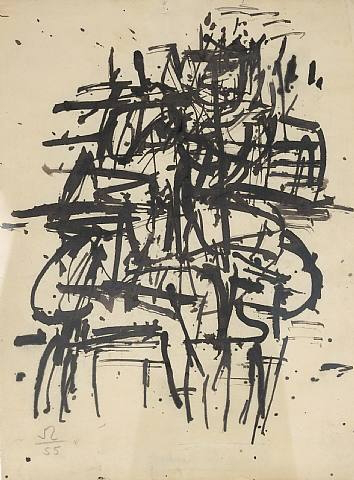

In [5]:
explore = ImageFolder(DATA_DIR)
explore[50][0]

In [6]:
###########################
##### set parameters ######
###########################
image_size = (64,64)      # size of each image
batch_size = 32           # how many images are processing at once
latent_size = 100         # the dimensionality of the random noise vector that is used as input to the generator network
epoch_restore = 150       # epoch times

checkpoint_path = "../input/abstract-art-generation-dcgan-checkpoints/{}epochs.chkpt".format(epoch_restore)

learning_rate = 0.0002
beta1 = 0.5               # the exponential decay rate for the first moment estimate in the Adam optimizer
epochs = 20

# load data
dataset = ImageFolder(root=DATA_DIR,
                      transform= T.Compose([T.Resize(image_size),
                                            T.ToTensor(),
                                            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])           
                      )
dataloader = DataLoader(dataset=dataset, batch_size=batch_size,shuffle=True,num_workers=2)
# prep device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [7]:
# getting a batch from the dataloader 
batch = next(iter(dataloader))

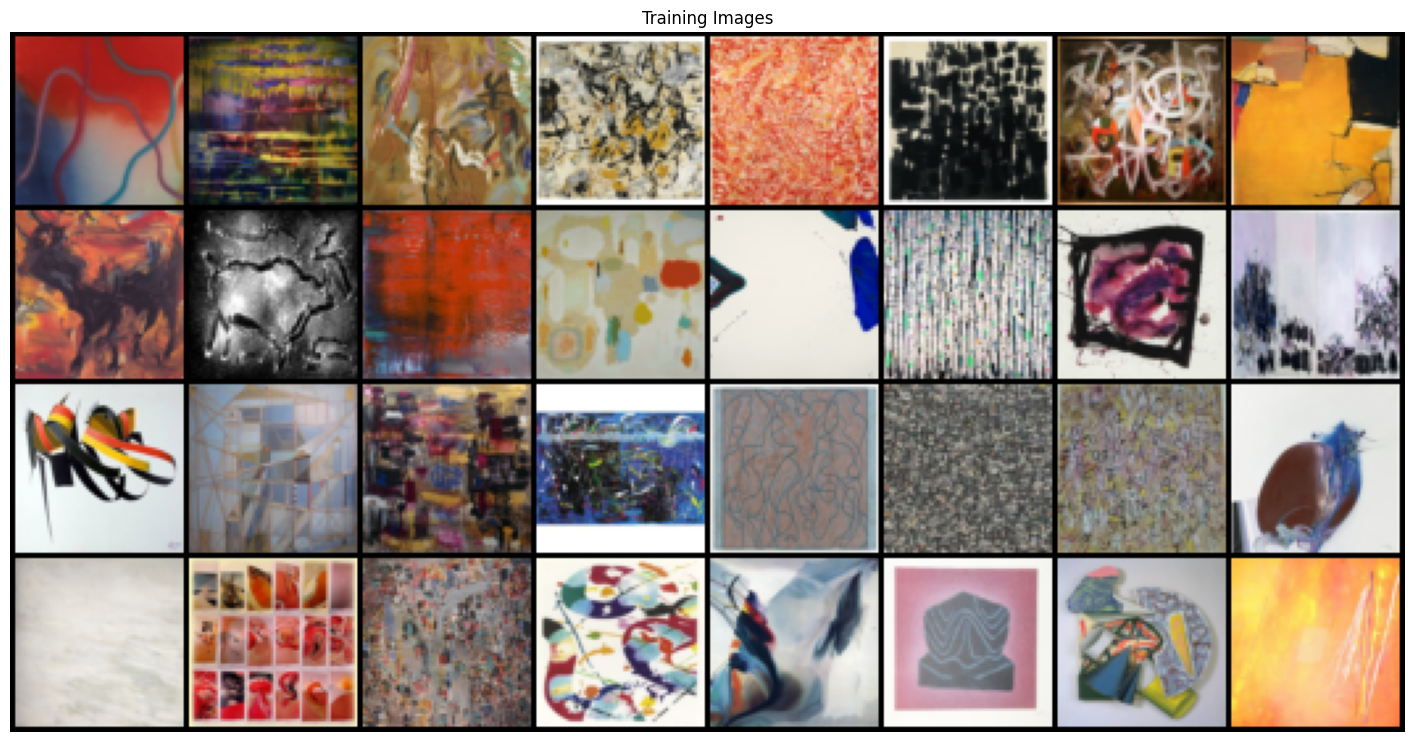

In [8]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")
# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

## DCGAN Model

In [9]:
def init_weights(m):
  class_name = m.__class__.__name__
  if class_name.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif class_name.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [45]:
from pyparsing.helpers import Sequence
############################
######## Generator #########
############################
class Generator(nn.Module):
  def __init__(self, ngpu=0):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
      # conv1
      nn.ConvTranspose2d(in_channels=latent_size, out_channels=64*8,kernel_size=4,stride=1,padding=0,bias=False),
      nn.BatchNorm2d(num_features=64*8),
      nn.ReLU(True),
      # conv2
      nn.ConvTranspose2d(in_channels=64*8, out_channels=64*4,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64*4),
      nn.ReLU(True),
      # conv3
      nn.ConvTranspose2d(in_channels=64*4, out_channels=64*2,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64*2),
      nn.ReLU(True),
      # conv4
      nn.ConvTranspose2d(in_channels=64*2, out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64),
      nn.ReLU(True),
      # conv 5
      nn.ConvTranspose2d(in_channels=64, out_channels=3,kernel_size=4,stride=2,padding=1,bias=False),
      nn.Tanh()
    )

  def forward(self, input):
    return self.main(input)



In [46]:
# Create the generator
ngpu=0
netG = Generator(ngpu).to(device)

# calculate the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(init_weights)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [47]:
print("Trainable Parameters:", count_parameters(netG))
untrained_output = netG(torch.randn(1, 100, 1, 1, device=device))
print(untrained_output.shape)

Trainable Parameters: 3576704
torch.Size([1, 3, 64, 64])


In [53]:
from torch.nn.modules.activation import LeakyReLU
################################
######## Discriminator #########
################################
class Discriminator(nn.Module):
  def __init__(self,ngpu):
    super(Discriminator,self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # conv1: input 3*64*64; output: 64*32*32 [32=(64-4+2)/2+1]
      nn.Conv2d(in_channels=3, out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
      nn.LeakyReLU(0.2,True),
      # conv2: input 64*32*32; output: 128*16*16 [32=(32-4+2)/2+1]
      nn.Conv2d(in_channels=64, out_channels=64*2,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64*2),
      nn.LeakyReLU(0.2,True),
      # conv3: input 128*16*16; output: 256*8*8
      nn.Conv2d(in_channels=64*2, out_channels=64*4,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64*4),
      nn.LeakyReLU(0.2,True),
      # conv4: input 256*8*8; output: 512*4*4
      nn.Conv2d(in_channels=64*4, out_channels=64*8,kernel_size=4,stride=2,padding=1,bias=False),
      nn.BatchNorm2d(num_features=64*8),
      nn.LeakyReLU(0.2,True),
      # conv5: input 512*4*4
      nn.Conv2d(in_channels=512, out_channels=1,kernel_size=4,stride=1,padding=0,bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    return self.main(input)


In [54]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netD.apply(init_weights)

# Print the model
print(netD)
print("Trainable Parameters:", count_parameters(netD))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
Trainable Parameters: 2765568


In [55]:
untrained_output = netG(torch.randn(1, 100, 1, 1, device=device))
print(untrained_output.shape)
netD(untrained_output).view(-1).detach()

torch.Size([1, 3, 64, 64])


tensor([0.1666])

## Loss Function and Optimization

In [56]:
import torch.optim as optim
############################
######## Loss Func #########
############################
criterion = nn.BCELoss()
sample_noise = torch.randn(batch_size,latent_size,1,1)
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [59]:
################################
######## Training Loop #########
################################
# list for tracking the training
img_list = []
iters = 0
G_losses = []
D_losses = []
print("Starting Training Loop...")
for epoch in range(epochs):
  for i, data in enumerate(dataloader,0):
    #####################################################################
    # Update Discriminator network: maximize log(D(x)) + log(1-D(G(z))) #
    #####################################################################
    # Train with all-real batch
    netD.zero_grad()                              # set the gradients of all parameters in a neural network to zero
    real_data = data[0].to(device)                # generate real pictures
    real_size = real_data.size(0)
    label = torch.ones(real_size, dtype=torch.float32, device=device)
    output = netD(real_data).view(-1)             # run discriminator
    error_real_batch = criterion(output,label)    # loss of real batch
    error_real_batch.backward() 
    D_x = output.mean().item()                      # This value is a measure of how well the discriminator is able to distinguish between real and fake samples, with a higher value indicating better performance

    # Train with all-fake batch
    noise = torch.randn(real_size,latent_size,1,1,device=device)
    fake_data = netG(noise)
    label.fill_(fake_label)
    output = netD(fake_data.detach()).view(-1)    #  remove a tensor from the computation graph that tracks operations involving tensors
    error_fake_batch = criterion(output, label)
    error_fake_batch.backward()

    # sum of discriminator
    error_discriminator = error_real_batch + error_fake_batch
    optimizerD.step()

    ################################################################
    # Update Generatornetwork: maximize log(D(x)) + log(1-D(G(z))) #
    ################################################################
    netG.zero_grad()
    label.fill_(real_label)
    output = netD(fake_data).view(-1) 
    error_generator = criterion(output, label)
    error_generator.backward()
    optimizerG.step()

    if i % 10 == 0:
      tqdm.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     error_discriminator.item(), error_generator.item()))
            
    D_losses.append(error_discriminator.item())
    G_losses.append(error_generator.item())

    # Check how the generator is doing by saving G's output on sample_noise
    if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = netG(sample_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    iters += 1


Starting Training Loop...
[0/20][0/87]	Loss_D: 0.0001	Loss_G: 11.9115
[0/20][10/87]	Loss_D: 0.0006	Loss_G: 25.3110
[0/20][20/87]	Loss_D: 0.4100	Loss_G: 32.1816
[0/20][30/87]	Loss_D: 18.7833	Loss_G: 11.6350
[0/20][40/87]	Loss_D: 0.9984	Loss_G: 15.5829
[0/20][50/87]	Loss_D: 0.0692	Loss_G: 10.8233
[0/20][60/87]	Loss_D: 1.6834	Loss_G: 14.9739
[0/20][70/87]	Loss_D: 0.1260	Loss_G: 4.6487
[0/20][80/87]	Loss_D: 0.3637	Loss_G: 7.8786
[1/20][0/87]	Loss_D: 0.2405	Loss_G: 5.9512
[1/20][10/87]	Loss_D: 0.4660	Loss_G: 6.7897
[1/20][20/87]	Loss_D: 0.4111	Loss_G: 5.2138
[1/20][30/87]	Loss_D: 0.8274	Loss_G: 11.2537
[1/20][40/87]	Loss_D: 0.8602	Loss_G: 6.8365
[1/20][50/87]	Loss_D: 0.7847	Loss_G: 6.4517
[1/20][60/87]	Loss_D: 0.5513	Loss_G: 6.5199
[1/20][70/87]	Loss_D: 0.5661	Loss_G: 7.6845
[1/20][80/87]	Loss_D: 0.3362	Loss_G: 5.9760
[2/20][0/87]	Loss_D: 0.2055	Loss_G: 5.5451
[2/20][10/87]	Loss_D: 0.1709	Loss_G: 6.4840
[2/20][20/87]	Loss_D: 0.7189	Loss_G: 8.4190
[2/20][30/87]	Loss_D: 0.5455	Loss_G: 7.7205


## Visualization of Results

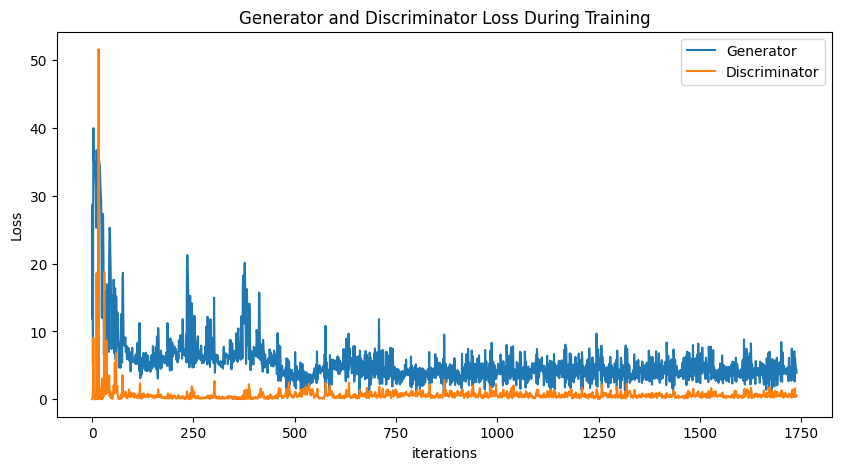

In [61]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

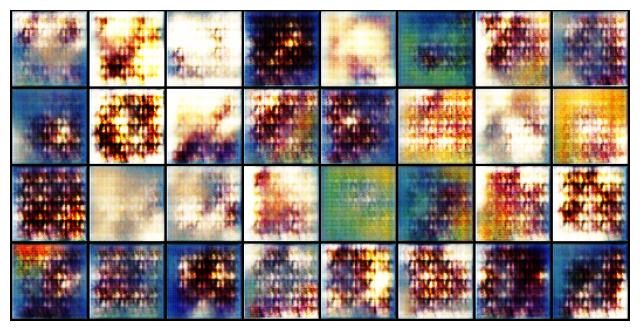

In [63]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())